# SVM with dense word embeddings on GPU using cuml

When trying to use (high-dimensional) word embeddings to train a support vector machine (SVM) classifier, the computation will be slow on CPU. However, the most widely used library for SVM is [scikit-learn](https://scikit-learn.org/stable/) that [does not support GPU](https://scikit-learn.org/stable/faq.html#will-you-add-gpu-support) for this algorithm. Meanwhile, [cuML](https://docs.rapids.ai/api/cuml/stable/) offers a GPU alternative. 

This notebook demonstrates how to use GPU supported SVM by cuML on Named Entity Recognition (NER) task, based on the [conll-2003](https://huggingface.co/datasets/conll2003) dataset and [word2vec-google-news-300](https://code.google.com/archive/p/word2vec/) word embedding.

*To run this notebook, [CUDA](https://developer.nvidia.com/cuda-toolkit) (supported version: 11.2, 11.8, 12.0, 12.2), [cuDNN](https://developer.nvidia.com/cudnn) and a CUDA capable GPU is required.*

In [ ]:
import csv
import torch # importing torch for bug resolve: https://github.com/cupy/cupy/issues/6325#issuecomment-1342675711
import cupy as cp
from cuml.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
trainfile = 'data/conll2003.train.conll'
devfile = 'data/conll2003.dev.conll'
testfile = 'data/conll2003.test.conll'

## Loading word embeddings

Use gensim to load google's word2vec word embeddings

In [ ]:
import gensim
import gensim.downloader
word_embedding_model = gensim.downloader.load("word2vec-google-news-300")

The following function gets the word embeddings of the tokens from the conll data

In [4]:
def convert_to_embeddings_with_gold_labels(conllfile,word_embedding_model):
    '''
    This function convert the .conll file to get word embeddings and gold labels
    '''
    labels, features = [],[]
    conllinput = open(conllfile, 'r')
    csvreader = csv.reader(conllinput, delimiter='\t',quotechar='|')
    
    for row in csvreader:
        if len(row) > 3:
            if row[0] in word_embedding_model:
                vector = word_embedding_model[row[0]]
            else:
                vector = [0]*300
            features.append(vector)
            labels.append(row[-1])
            
    return features, labels

In [5]:
train_embeddings, train_targets = convert_to_embeddings_with_gold_labels(trainfile,word_embedding_model)

Every line of the original conll data is now converted to the 300d embeddings of the token and its corresponding gold label

## Convert Data
cuML requires its own data type (e.g. `cp.float32` or `cp.int64`. We need to convert the embeddings before use.

Meanwhile, the gold labels ('O', 'B-LOCK', etc.) also needs to be converted into cp integers, we can make a dictionary for that (and its reverse for mapping back)

In [6]:
def get_label_maps(label_list):
    map_dict = dict(zip(set(label_list), range(len(set(label_list)))))
    map_dict_reverse = {v: k for k, v in map_dict.items()}
    return map_dict, map_dict_reverse

label_map, label_map_reverse = get_label_maps(train_targets)

In [7]:
print(label_map)

{'I-PER': 0, 'B-LOC': 1, 'I-ORG': 2, 'B-PER': 3, 'B-MISC': 4, 'I-LOC': 5, 'I-MISC': 6, 'O': 7, 'B-ORG': 8}


In [8]:
def convert_to_cupy_dtype(training_features, gold_labels, dict):
    '''
    This function converts data to cuml required cp data type
    '''
    cp_feature = cp.array(training_features, dtype=cp.float32)
    int_gold = [dict[line] for line in gold_labels]
    cp_gold = cp.array(int_gold, dtype=cp.int64)
    return cp_feature, cp_gold

In [9]:
cp_train_emb, cp_train_gold = convert_to_cupy_dtype(train_embeddings, train_targets, label_map)

## Train a SVC

We will need a scaler for the embedding data. For more detials, see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [10]:
scaler = StandardScaler()
scaler.fit(cp_train_emb.get())

StandardScaler()

We can then train a SVC with the scaler and certain hyperparameters. It's possible to do grid search to find best parameters. We'll do that in the following sections.

In [11]:
svc = make_pipeline(scaler, SVC(C=1, gamma=1))
svc.fit(cp_train_emb.get(), cp_train_gold)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

We can now test this SVC with test data:

In [12]:
test_embeddings, test_gold = convert_to_embeddings_with_gold_labels(testfile, word_embedding_model)
cp_test_emb, cp_test_gold = convert_to_cupy_dtype(test_embeddings, test_gold, label_map)

predictions = svc.predict(cp_test_emb.get()).tolist()

Note that we need to map the int labels back. Let's inspect the first 20 results:

In [13]:
predictions = [label_map_reverse[line] for line in predictions]
print(tuple(zip(predictions,test_gold))[:20])

(('O', 'O'), ('O', 'O'), ('O', 'B-LOC'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('I-ORG', 'B-PER'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'O'), ('O', 'B-PER'), ('O', 'I-PER'), ('O', 'B-LOC'), ('O', 'O'), ('B-LOC', 'B-LOC'), ('B-MISC', 'I-LOC'), ('I-LOC', 'I-LOC'), ('O', 'O'))


## Inspect the Results
You can do this easily with:

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [15]:
report = classification_report(test_gold, predictions, digits = 7, target_names = set(train_targets), output_dict=True)
report

{'I-PER': {'precision': 0.8078602620087336,
  'recall': 0.776378896882494,
  'f1-score': 0.7918067869153165,
  'support': 1668.0},
 'B-LOC': {'precision': 0.7794612794612794,
  'recall': 0.6595441595441596,
  'f1-score': 0.7145061728395061,
  'support': 702.0},
 'I-ORG': {'precision': 0.7953917050691244,
  'recall': 0.5195665261890428,
  'f1-score': 0.6285506190823016,
  'support': 1661.0},
 'B-PER': {'precision': 0.8432055749128919,
  'recall': 0.4489795918367347,
  'f1-score': 0.5859564164648909,
  'support': 1617.0},
 'B-MISC': {'precision': 0.6129032258064516,
  'recall': 0.5175097276264592,
  'f1-score': 0.5611814345991561,
  'support': 257.0},
 'I-LOC': {'precision': 0.5981308411214953,
  'recall': 0.5925925925925926,
  'f1-score': 0.5953488372093022,
  'support': 216.0},
 'I-MISC': {'precision': 0.6897810218978102,
  'recall': 0.45269461077844314,
  'f1-score': 0.5466377440347072,
  'support': 835.0},
 'O': {'precision': 0.590027700831025,
  'recall': 0.1842560553633218,
  'f1-s

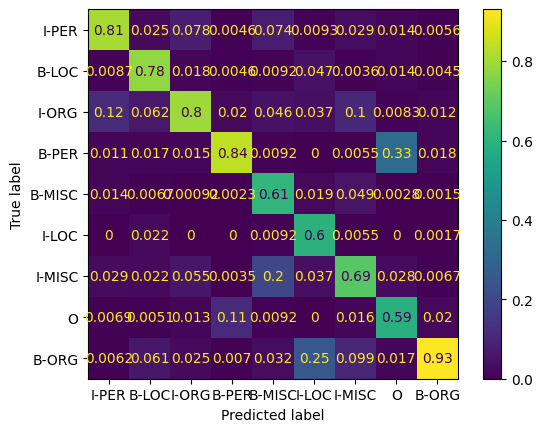

In [16]:
cf_matrix = confusion_matrix(test_gold, predictions, normalize = 'pred')
matrix_display = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels = set(train_targets))
matrix_display.plot()

## Parameter Grid Search

To obtain a better set of hyperparameters (C, gamma), it's possible to run a grid search.

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
dev_embeddings, dev_gold = convert_to_embeddings_with_gold_labels(devfile, word_embedding_model)
cp_dev_emb, cp_dev_gold = convert_to_cupy_dtype(dev_embeddings, dev_gold, label_map)

In [19]:
scaler = StandardScaler()
scaler.fit(cp_dev_emb.get())
svc = make_pipeline(scaler, SVC())

*(The reason why the output of the following cell is suppressed with `%%capture` is [an unsolved issue of cuML](https://github.com/rapidsai/cuml/issues/5721), it does not affect the parameter output)*

In [20]:
%%capture
param_grid = {"svc__gamma": [0.1, 1.0, 10, 100], "svc__C": [0.1, 1.0, 10, 100]}
grid_search = GridSearchCV(svc, param_grid, cv=3)
grid_search.fit(cp_dev_emb.get(), cp_dev_gold.get())

Note that this grid search can take long on large dataset. You can smaller the parameter grid or the number of cv to run it faster. Meanwhile, if you encounter GPU out of memory `MemoryError: std::bad_alloc: out_of_memory`, you may have met [this bug](https://github.com/rapidsai/cuml/issues/5769) and you can check details on solving it in the link.

In [21]:
print("According to GridSearchCV, the best parameter for SVC over embedding is", grid_search.best_params_)

According to GridSearchCV, the best parameter for SVC over embedding is {'svc__C': 100, 'svc__gamma': 10}


You can use the updated hyperparameters now.